In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from dataloader import get_evaluation_datasets_by_client  # Assuming this function gets local client datasets
from model import Net
from collections import OrderedDict
from config import NUM_CLASSES, NUM_CLIENTS, GLOBAL_MODEL_PATH, BATCH_SIZE
from torch.utils.data import DataLoader
from utils import to_tensor
import pandas as pd

/home/sharedrive/PythonCodes/.venv311_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper Functions

In [2]:
# Load the global model from the saved path
def load_model(model_path=GLOBAL_MODEL_PATH, num_classes=NUM_CLASSES):
    model = Net(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [3]:
# Run inference on a client's dataset
def run_inference(model, dataloader, device):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            features, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(features)
            _, preds = torch.max(outputs.data, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes, title, ax):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, ax=ax)  # Pass ax here directly
    ax.set_title(title)  # Optional: Set a title for each subplot


## Accumulate Results
- Accumulate all thre results and save in csv file
- It also stores values reauired for confusion matrix in a varialbe

In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
client_metrics = {
    'Component': [],
    'Fold': [],
    'Client': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Sample Number': []
}

result_sources = {
    'components': [40],
    'folds': [1],
    'clients': [1, 2, 3, 4],
    'path': './results/pca_{0}_fold_{1}'
}

classes = np.arange(NUM_CLASSES)  # Define or import this variable

def accumulate_results(results, confusion_matrix_data):
    components = results.get('components')
    folds = results.get('folds')
    path = results.get('path')
    clients = results.get('clients')
     
    for component in components:  
        for fold in folds:
            global_model = path.format(component, fold) + '/' + 'global_model.pth'
            history = path.format(component, fold) + '/' + 'history.pkl'
            training_time = path.format(component, fold) + '/' + 'training_time.txt'
            
            model = load_model(model_path=global_model)
            model.to(device)    
            num_clients = NUM_CLIENTS  # Define or import this variable    
            
            for client in clients:                                
                testset = get_evaluation_datasets_by_client(client)  
                testloader = DataLoader(to_tensor(testset), batch_size=BATCH_SIZE)
                preds, labels = run_inference(model, testloader, device)
                client_metrics['Component'].append(component)
                client_metrics['Fold'].append(fold)
                client_metrics['Client'].append(client)
                client_metrics['Accuracy'].append(accuracy_score(labels, preds))
                client_metrics['Precision'].append(precision_score(labels, preds))
                client_metrics['Recall'].append(recall_score(labels, preds))
                client_metrics['F1 Score'].append(f1_score(labels, preds))
                client_metrics['Sample Number'].append(len(labels))

                #Saving info for confusion matrix
                key = f'{component}_{fold}_{client}'
                confusion_matrix_data[key] = {
                    'preds': preds,
                    'labels': labels,
                    'classes': np.arange(NUM_CLASSES)
                }   

    ##Converting into datafram for better visualization
    df = pd.DataFrame(client_metrics)
    print(df.to_string(index=False))
    return df, confusion_matrix_data           
    

In [70]:
confusion_matrix_data = {}
result_df, store_results_df = accumulate_results(result_sources, confusion_matrix_data)

 Component  Fold  Client  Accuracy  Precision  Recall  F1 Score  Sample Number
        40     1       1       1.0        1.0     1.0       1.0          84000
        40     1       2       1.0        1.0     1.0       1.0          84000
        40     1       3       1.0        1.0     1.0       1.0          84000
        40     1       4       1.0        1.0     1.0       1.0          84000


## Confusion Matrix

In [76]:
plots = [
    {
        'client_id': 1,
        'plot_name': 'Client 1',
        'plot_position': [0, 0]
    },
    {
        'client_id': 2,
        'plot_name': 'Client 2',
        'plot_position': [0, 1]
    },
    {
        'client_id': 3,
        'plot_name': 'Client 3',
        'plot_position': [1, 0]
    },
    {
        'client_id': 4,
        'plot_name': 'Client 4',
        'plot_position': [1, 1]
    }   
]

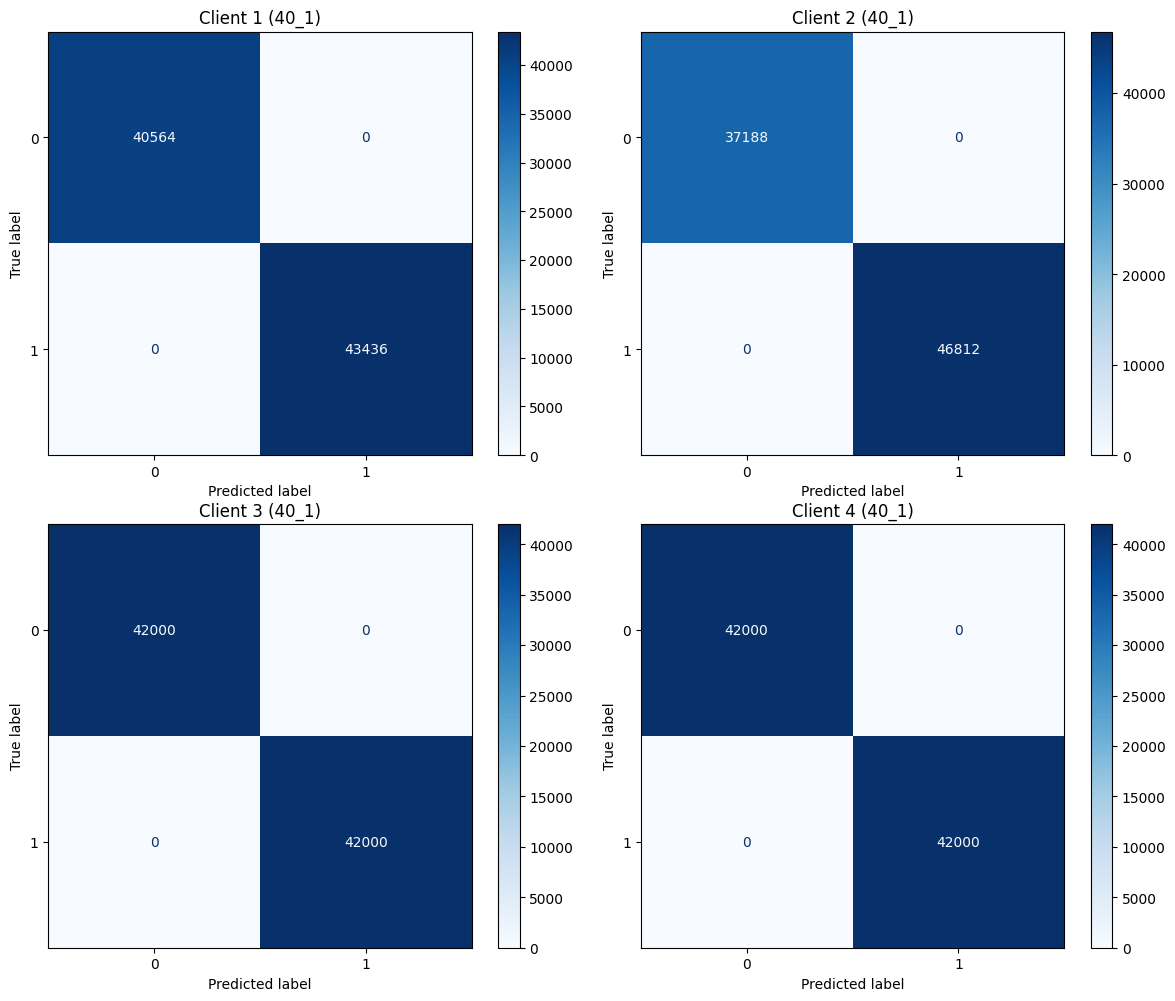

In [78]:
result_sources = {
    'components': [40],
    'folds': [1],
    'clients': [1, 2, 3, 4],
    'path': './results/pca_{0}_fold_{1}'
}

for component in result_sources.get('components'):
    for fold in result_sources.get('folds'):
        #print(f" Plots for Components: {component}, and Folds: {fold}")
        fig, ax = plt.subplots(2, 2, figsize=(12, 10))  # Adjust the figsize as needed
        for plot in plots:
            client = plot.get('client_id')
            key = f'{component}_{fold}_{client}'
            data = confusion_matrix_data[key]
            title = "{0} ({1}_{2})".format(plot['plot_name'], component, fold)
            plot_confusion_matrix(data['labels'], data['preds'], data['classes'], title, ax = ax[plot['plot_position'][0], plot['plot_position'][1]])
        plt.tight_layout()
        plt.show()

